In [1]:
%%capture
%matplotlib notebook 


import numpy as np
import math
import matplotlib.pyplot as plot
from matplotlib import ticker

from sklearn.metrics import r2_score

###############################################################################
# Lasso and Linear
from sklearn.linear_model import Lasso,LinearRegression

import matplotlib
from mpl_toolkits.mplot3d import Axes3D

import scipy.optimize as sciop
from scipy.optimize import basinhopping

!make fortran;
import irreverisble #importing the fortran mechanics routine

global exp
exp = []                           # ***** target 
exp = np.loadtxt('ref/HSRS/22')

def error_evaluation_rms(errors):
    
    sum_of_squares = 0
    
    for error in errors:
        sum_of_squares = sum_of_squares + error**2
        
    return ((sum_of_squares/len(errors))**(1./2.)) #incorporated division by n, which is the proper rms 

def mcfunc(model_parameters):

    # -------------- number samples, =1 in this case
    no_samples = 1
    T_service = 22. + 273.
    prec_stress = 0
    SS_stress = 750
    
    strain_stress, WTN = irreverisble.mechanics(prec_stress,SS_stress,T_service,model_parameters,no_samples)
    strain_stress = np.array(np.trim_zeros(strain_stress)).reshape(-1,2)
    #print strain_stress
    
    #----------------------------
    cal_val = []
    errors = []
    
    #traverses experimental data points
    for iexp, data in enumerate(exp[:,0]):
        
        #finding nearest neighbors that surround the data points, and using them to determine the error
        for ical, data in enumerate(strain_stress[:,0]):
            
            ical = ical-1 # May or may not be advantageous to keep this instead of the range attribute for mem save
            
            left_strainpoint = strain_stress[ical,0]
            right_strainpoint = strain_stress[ical+1,0]
            
            exp_datapoint = exp[iexp,0]
            
            if(exp_datapoint>left_strainpoint and exp_datapoint<right_strainpoint):
                                
                # stores the differences between the successive approximations so we interpolate
                left_difference = exp_datapoint-left_strainpoint
                right_difference = right_strainpoint-exp_datapoint
                
                total_difference = left_difference+right_difference
                
                left_weight = left_difference/total_difference
                right_weight = right_difference/total_difference
                  
                # interpolate stress based on strain?
                interpolated_strain = left_weight*left_strainpoint + right_weight*right_strainpoint
                interpolated_stress = left_weight*strain_stress[ical,1] + right_weight*strain_stress[ical+1,1]
                    
                stress_error = interpolated_stress - exp[iexp,1]    
                #print stress_error
                
                #adds value, we want to find difference between these approximated data points and the real results
                cal_val.append([interpolated_strain,interpolated_stress])                 
                errors.append(stress_error)
                
                break
    
    #print errors
    error_rms = error_evaluation_rms(errors)    
    cal_val = np.asarray(cal_val)
    
    #print cal_val
    #----------------------------
    
    # return error as well as the results of stress-strain curve?
    return strain_stress, error_rms


"""
def IntervalPlot3D(xlabel="",ylabel="",zlabel="",title="",fontsize=14):


    fig = plt.figure()
    ax = fig.gca(projection='3d')
    plt.title(title)
    matplotlib.rcParams.update({'font.size': fontsize})
    
    interval = 1.

    x_domain = np.arange(-102.,-94.,interval)
    y_domain = np.arange(5.,15.,interval)

    x = np.zeros(0)
    y = np.zeros(0)

    for y_val in y_domain:

        x = np.append(x,x_domain)

        for x_val in x_domain:

            y = np.append(y,y_val)

    z = np.zeros(0)

    for index, value in enumerate(x):

        model_params = (x[index],y[index])
        z = np.append(z,mcfunc(model_params))

    ax.plot(x,y,z,"p")

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)

    plt.show()"""
    
#IntervalPlot3D(xlabel="Param 1",ylabel="Param 2",zlabel="Error from experimental results",title="Error", fontsize=16)

'\ndef IntervalPlot3D(xlabel="",ylabel="",zlabel="",title="",fontsize=14):\n\n\n    fig = plt.figure()\n    ax = fig.gca(projection=\'3d\')\n    plt.title(title)\n    matplotlib.rcParams.update({\'font.size\': fontsize})\n    \n    interval = 1.\n\n    x_domain = np.arange(-102.,-94.,interval)\n    y_domain = np.arange(5.,15.,interval)\n\n    x = np.zeros(0)\n    y = np.zeros(0)\n\n    for y_val in y_domain:\n\n        x = np.append(x,x_domain)\n\n        for x_val in x_domain:\n\n            y = np.append(y,y_val)\n\n    z = np.zeros(0)\n\n    for index, value in enumerate(x):\n\n        model_params = (x[index],y[index])\n        z = np.append(z,mcfunc(model_params))\n\n    ax.plot(x,y,z,"p")\n\n    ax.set_xlabel(xlabel)\n    ax.set_ylabel(ylabel)\n    ax.set_zlabel(zlabel)\n\n    plt.show()'

In [ ]:
"""import numpy as np
import scipy as sp
import matplotlib.pyplot as plot

from scipy.optimize import minimize

import timeit
from memory_profiler import memory_usage

#all methods to minimize
methods = ['Powell','CG','SLSQP']

start = np.zeros(0)
stop = np.zeros(0)
num_iters = np.zeros(0)

most_mem = np.zeros(0)
result = []

#runtime code goes here

function = mcfunc

#testing every minimization method
for method in methods:
    
    mem_use = memory_usage(-1,interval=0.1)
    start = np.append(start,timeit.default_timer())
    
    guess = [-5.,10.] # guess for correct minimum
    
    # Possibly was finding the iterations in the wrong order
    current_result = minimize(function, x0 = guess, method = method,tol=1e-6)
    result.append(current_result)
    
    keys = current_result.keys() # contains all traits of result
    iterations = -1
    
    if 'nit' in keys:    
        iterations = current_result.get('nit')
        
  ,'BFGS','L-BFGS-B','TNC','COBYLA','SLSQP'  num_iters = np.append(num_iters,iterations)
    stop = np.append(stop,timeit.default_timer())
    
    # tracks amount of memory used
    most_mem = np.append(most_mem,max(mem_use)) 

exec_time = stop-start

# If an algorithm took (-1) iterations, the number of iterations was not returned
for counter, method in enumerate(methods):
    
    print '{0} took {1} seconds. The result, {4} was found at ({2}, {3})'.format(method,exec_time[counter],result[counter].x[0],result[counter].x[1],result[counter].fun)
    print '{0} used {1} megabytes and took {2} iterations'.format(method,most_mem[counter],num_iters[counter])
    print
    """

### The listing results have been corrected!
Powell took 56.1397018433 seconds. The result, 397.946431233 was found at (-97.2243276084, 15.2352005544)
Powell used 87.65234375 megabytes and took 2.0 iterations

CG took 841.190486193 seconds. The result, 397.94643127 was found at (-97.220916748, 10.0)
CG used 87.66015625 megabytes and took 47.0 iterations

SLSQP took 19.0377500057 seconds. The result, 397.946431256 was found at (-97.2270084708, 10.0)
SLSQP used 87.72265625 megabytes and took 10.0 iterations

### Trying basinhopping to find the minimum of our error

In [ ]:
%%capture
"""import numpy as np
import scipy as sp
import matplotlib.pyplot as plot

from scipy.optimize import minimize

import timeit
from memory_profiler import memory_usage

start = np.zeros(0)
stop = np.zeros(0)
num_iters = np.zeros(0)

most_mem = np.zeros(0)

#runtime code goes here

function = mcfunc

#testing every minimization method
for method in methods:
    
    mem_use = memory_usage(-1,interval=0.1)
    start = np.append(start,timeit.default_timer())
    
    guess = [-5.,10.] # guess for correct minimum
    
    # Possibly was finding the iterations in the wrong order
    result = basinhopping(function, x0 = guess)
    
    keys = result.keys() # contains all traits of result
    iterations = -1
    
    if 'nit' in keys:    
        iterations = result.get('nit')
        
    num_iters = np.append(num_iters,iterations)
    stop = np.append(stop,timeit.default_timer())
    
    # tracks amount of memory used
    most_mem = np.append(most_mem,max(mem_use)) 

exec_time = stop-start

# If an algorithm took (-1) iterations, the number of iterations was not returned
for counter, method in enumerate(methods):
    
    print '{0} took {1} seconds. The result, {4} was found at ({2}, {3})'.format(method,exec_time[counter],result.x[0],result.x[1],result.fun)
    print '{0} used {1} megabytes and took {2} iterations'.format(method,most_mem[counter],num_iters[counter])
    print"""

Basinhopping took 1963.73302293 seconds. The result, 397.946431233 was found at (-97.2243260013, 11.9417785317)
Basinhopping used 102.2734375 megabytes and took 100.0 iterations (Same result as local minimization)

### Now, we should make this testing method a class that can be called (Will do this outside notebook)

In [ ]:
#import test_suite

#test_suite.minimize_suite(mcfunc,['Powell','SLSQP'],[-500.,1.])

### Performing this with all functions to evaluate if memory issue was solved

In [ ]:
#import test_suite

#test_suite.minimize_suite(mcfunc,['Nelder-Mead','SLSQP'],[-500.,1.])

Nelder-Mead took 73.8156878948 seconds. The result, 397.946431233 was found at (-97.2243219614, 1.62465067804)
Nelder-Mead used 87.56640625 megabytes and took 69.0 iterations

Powell took 102.296751022 seconds. The result, nan was found at (-27.4739053532, 0.274894413458)
Powell used 87.5703125 megabytes and took 28.0 iterations

CG took 967.848807096 seconds. The result, 397.946431246 was found at (-97.226373943, 1.35675756514)
CG used 87.5703125 megabytes and took 52.0 iterations

BFGS took 32.2478640079 seconds. The result, nan was found at (-315655.4971, -44984.1665113)
BFGS used 87.6328125 megabytes and took 3.0 iterations

L-BFGS-B took 30.2151210308 seconds. The result, 397.946431622 was found at (-97.2352796645, 57.1105312168)
L-BFGS-B used 87.7578125 megabytes and took 6.0 iterations

TNC took 12.0557310581 seconds. The result, 421.937094344 was found at (-500.0, 1.0)
TNC used 87.92578125 megabytes and took 0.0 iterations

COBYLA took 474.013291836 seconds. The result, 412.637188539 was found at (-272.261846785, 2.36548167553)
COBYLA used 87.9296875 megabytes and took -1.0 iterations

SLSQP took 36.7581448555 seconds. The result, 397.946431938 was found at (-97.2095787659, 58.2472771029)
SLSQP used 87.93359375 megabytes and took 17.0 iterations

In [ ]:
import test_suite

test_suite.minimize_suite(mcfunc,['Nelder-Mead','SLSQP'],[-500.,1.])

### The memory functionality seems to be working, let's try it with all functions one time

In [8]:
import test_suite

test_suite.minimize_suite(mcfunc,['Powell'],[-100.,1.])

Powell took 98.0354118347 seconds. The result, nan was found at (-27.4867516679, 0.274970173161)
Powell used 88.98828125 megabytes and took 28.0 iterations



Powell took 98.0354118347 seconds. The result, nan was found at (-27.4867516679, 0.274970173161)
Powell used 88.98828125 megabytes and took 28.0 iterations

In [2]:
import test_suite

test_suite.minimize_suite(mcfunc,['L-BFGS-B'],[-500.,1.])

L-BFGS-B took 29.7195749283 seconds. The result, 397.946431622 was found at (-97.2352796645, 57.1105312168)
L-BFGS-B used 87.44921875 megabytes and took 6.0 iterations



In [3]:
guess = [-500.,1.]
test_suite.minimize_suite(mcfunc,['Powell'],guess)

Powell took 97.9135229588 seconds. The result, nan was found at (-27.4739053532, 0.274894413458)
Powell used 87.4609375 megabytes and took 28.0 iterations



In [4]:
test_suite.minimize_suite(mcfunc,['Nelder-Mead'],guess)

Nelder-Mead took 73.7663280964 seconds. The result, 397.946431233 was found at (-97.2243219614, 1.62465067804)
Nelder-Mead used 87.61328125 megabytes and took 69.0 iterations



In [5]:
test_suite.minimize_suite(mcfunc,['SLSQP'],guess)

SLSQP took 35.7045919895 seconds. The result, 397.946431938 was found at (-97.2095787659, 58.2472771029)
SLSQP used 87.6171875 megabytes and took 17.0 iterations



In [7]:
test_suite.minimize_suite(mcfunc,['BFGS'],guess)

BFGS took 32.8787059784 seconds. The result, nan was found at (-315655.4971, -44984.1665113)
BFGS used 88.765625 megabytes and took 3.0 iterations



In [8]:
test_suite.minimize_suite(mcfunc,['TNC'],[guess])

TNC took 12.4638810158 seconds. The result, 421.937094344 was found at (-500.0, 1.0)
TNC used 88.76953125 megabytes and took 0.0 iterations



In [10]:
test_suite.minimize_suite(mcfunc,['TNC'],[-100.,1.])

TNC took 117.298631907 seconds. The result, 397.907686905 was found at (-93.1687640469, 0.878006535394)
TNC used 88.8125 megabytes and took 7.0 iterations



/site/x86/anaconda-1.8/anaconda/lib/python2.7/site-packages/scipy/optimize/optimize.py:558: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


TNC Seems to have printed a smaller result, let's verify that it's valid

In [12]:
print mcfunc((-93.16876,0.8780065))

397.907686942


### It seems that TNC gave us the best results but only with a very close initial guess

Now using these results, we can plot the stress-strain curve with (-93.1687,0.878) as our initial parameters

## Results with Ideal Parameters

<IPython.core.display.Javascript object>


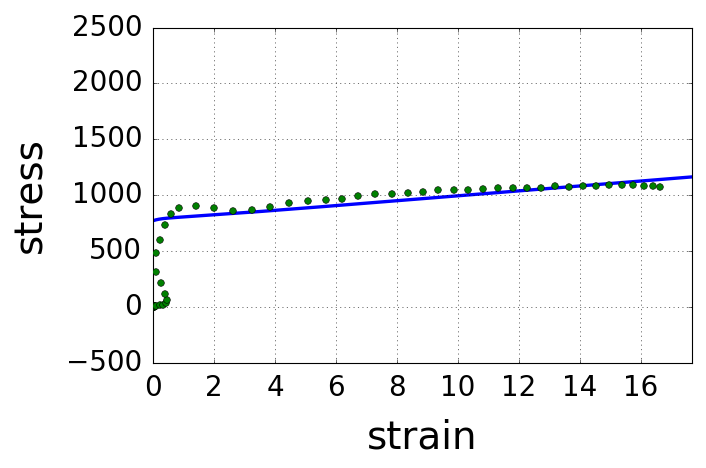

In [3]:
# we want to compare the results of the strain_stress with the experimental data to minimize error
import test_suite
strain_stress, error = mcfunc((-93.16876,0.8780065))
test_suite.plotSingle2D(strain_stress,'strain','stress','linear','linear')

In [11]:
"""def IntervalPlot3D(function, x_domain, y_domain, xlabel="",ylabel="",zlabel="",title="",fontsize=14):

    fig = plot.figure()
    ax = fig.gca(projection='3d')
    plt.title(title)
    matplotlib.rcParams.update({'font.size': fontsize})

    x = np.zeros(0)
    y = np.zeros(0)

    for y_val in y_domain:

        x = np.append(x,x_domain)

        for x_val in x_domain:

            y = np.append(y,y_val)

    z = np.zeros(0)

    for index, value in enumerate(x):

        z = np.append(z,function(x[index],y[index])

    ax.plot(x,y,z)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)

    plot.show()
    
IntervalPlot3D((lambda x,y : x+y**2), x_domain=np.arange(0,10,1.),y_domain=np.arange(0,10,1.))"""

SyntaxError: invalid syntax (<ipython-input-11-1fafa8b31d07>, line 25)

<IPython.core.display.Javascript object>


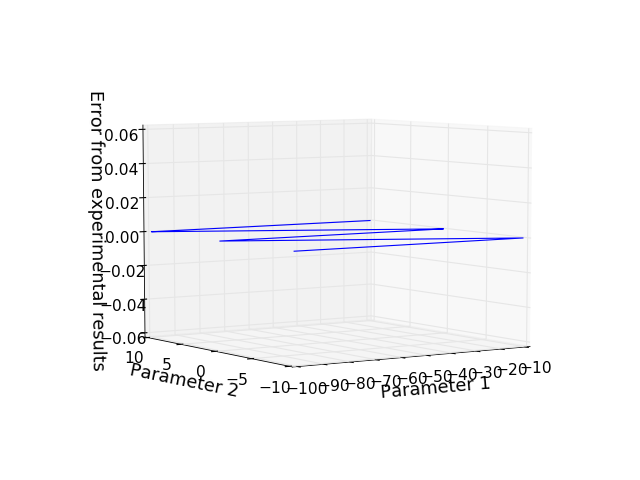

(array([[  3.26797386e-03,   7.71659057e+02],
       [  6.53594771e-03,              nan]]), nan)
(array([[  3.26797386e-03,   7.71659057e+02],
       [  6.53594771e-03,              nan]]), nan)
(array([[  3.26797386e-03,   7.71659057e+02],
       [  6.53594771e-03,              nan]]), nan)
(array([[  3.26797386e-03,   7.71659057e+02],
       [  6.53594771e-03,              nan]]), nan)
(array([[  3.26797386e-03,   7.71659057e+02],
       [  6.53594771e-03,              nan]]), nan)
(array([[  3.26797386e-03,   7.71659057e+02],
       [  6.53594771e-03,              nan]]), nan)
(array([[  3.26797386e-03,   7.71659057e+02],
       [  6.53594771e-03,              nan]]), nan)
(array([[  3.26797386e-03,   7.71659057e+02],
       [  6.53594771e-03,              nan]]), nan)
(array([[  3.26797386e-03,   7.71659057e+02],
       [  6.53594771e-03,              nan]]), nan)
(array([[  3.26797386e-03,   7.71659057e+02],
       [  6.53594771e-03,              nan]]), nan)
(array([[  3.2679738

In [12]:
"""
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

mpl.rcParams['legend.fontsize'] = 14

fig = plt.figure()
ax = fig.gca(projection='3d')

interval = 10.

x_domain = np.arange(-100.,0.,interval)
y_domain = np.arange(-10.,20.,interval)

x = np.zeros(0)
y = np.zeros(0)

for y_val in y_domain:
    
    x = np.append(x,x_domain)
    
    for x_val in x_domain:
       
        y = np.append(y,y_val)

z = np.zeros(0)
        
for index, value in enumerate(x):
    
    model_params = (x[index],y[index])
    print mcfunc(model_params)
    #z = np.append(z,mcfunc(model_params))
    
ax.plot(x,y,z,"p")

ax.set_xlabel("Parameter 1", fontsize = 16)
ax.set_ylabel("Parameter 2", fontsize = 16)
ax.set_zlabel("Error from experimental results", fontsize = 16)

plt.show()
"""

<IPython.core.display.Javascript object>


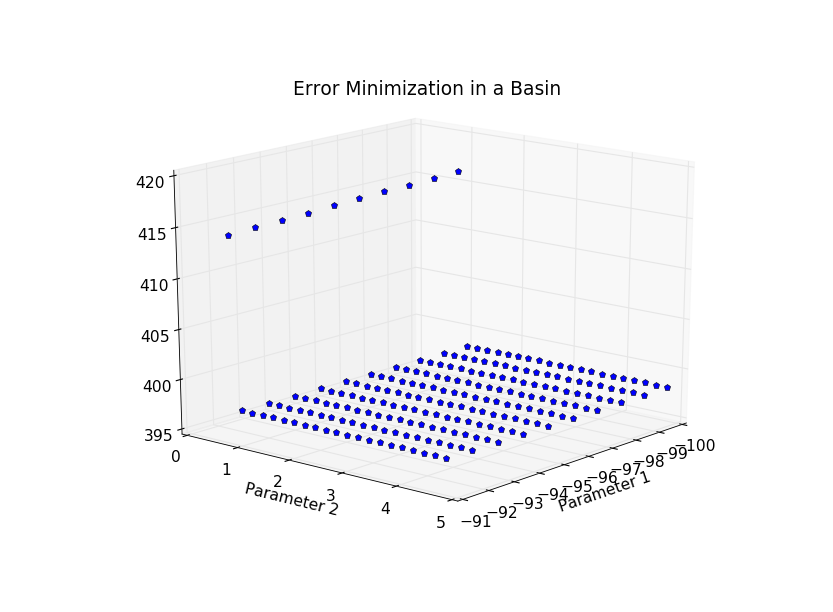

In [5]:
import test_suite
test_suite.IntervalPlot3D(mcfunc,np.arange(-100.,-90.,1.),np.arange(0.01,5.01,0.2),xlabel="Parameter 1",ylabel="Parameter 2", title = "Error Minimization in a Basin")